# CS1-MPC

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "Helvetica"
matplotlib.rcParams['font.size'] = 20

In [2]:
%rm -rf ANN_for_MPC_pretraining
! git clone https://github.com/panos108/ANN_for_MPC_pretraining.git
! pip install casadi
import casadi

Cloning into 'ANN_for_MPC_pretraining'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 108 (delta 62), reused 67 (delta 30), pack-reused 0
Receiving objects: 100% (108/108), 130.96 KiB | 331.00 KiB/s, done.
Resolving deltas: 100% (62/62), done.


Define Case Study

In [16]:
# GP NMPC problem setup
import numpy as np
from casadi import *

# DETERMINISTIC MODEL
class Bio_reactor:

    def specifications(self):
        ''' Specify Problem parameters '''
        tf              = 240.      # final time
        nk              = 12        # sampling points
        dt              = tf/nk
        Cx              = np.random.normal(1., np.sqrt(1e-3))
        Cn              = np.random.normal(150., np.sqrt(22.5))
        x0              = np.array([Cx, Cn, 0.])
        Lsolver         = 'mumps'  #'ma97'  # Linear solver
        c_code          = False    # c_code
        shrinking_horizon = True

        return dt, x0, Lsolver, c_code, shrinking_horizon

    def DAE_system(self):
        # Define vectors with names of states
        states     = ['x','n','q']
        nd         = len(states)
        xd         = SX.sym('xd',nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = []
        na         = len(algebraics)
        xa         = SX.sym('xa',na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        set_points = []
        n_ref      = len(set_points)
        x_ref      = SX.sym('x_ref',n_ref)
        for i in range(n_ref):
            globals()[set_points[i]] = x_ref[i]



        # Define vectors with banes of input variables
        inputs     = ['L','Fn']
        nu         = len(inputs)
        u          = SX.sym("u",nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        # Define model parameter names and values
        modpar    = ['u_m', 'k_s', 'k_i', 'K_N', 'u_d', 'Y_nx', 'k_m', 'k_sq',
        'k_iq', 'k_d', 'K_Np']
        modparval = [0.0923*0.62, 178.85, 447.12, 393.10, 0.001, 504.49,
        2.544*0.62*1e-4, 23.51, 800.0, 0.281, 16.89]

        nmp       = len(modpar)
        uncertainty = []#SX.sym('uncp', nmp)
        for i in range(nmp):
            globals()[modpar[i]] = SX(modparval[i])# + uncertainty[i])

        # Additive measurement noise
    #    Sigma_v  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Additive disturbance noise
    #    Sigma_w  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Initial additive disturbance noise
    #    Sigma_w0 = [1.,150.**2,0.]*diag(np.ones(nd))*1e-3
        # Declare ODE equations (use notation as defined above)

        dx   = u_m * L/(L+k_s+L**2./k_i) * x * n/(n+K_N) - u_d*x
        dn   = - Y_nx*u_m* L/(L+k_s+L**2./k_i) * x * n/(n+K_N)+ Fn
        dq   = (k_m * L/(L+k_sq+L**2./k_iq) * x - k_d * q/(n+K_Np))# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

              # * (tanh(1000*(500. - n))+1)/2 * (tanh(1000*(x - 10.000))+1)/2# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

        ODEeq =  [dx, dn, dq]

        # Declare algebraic equations
        Aeq = []

        # Define objective to be minimized
        t     = SX.sym('t')
        Obj_M = Function('mayer', [xd, x_ref, u], [-q])  # Mayer term
        Obj_L = Function('lagrange', [xd, x_ref, u], [0.])  # Lagrange term
        Obj_D = Function('Discrete', [xd, x_ref, u], [0.])  # Lagrange term

        R           = np.diagflat([3.125e-8, 3.125e-006])    # Weighting of control penality

        # Define control bounds
        u_min = np.array([120., 0.])
        u_max = np.array([400., 40.])
        x_min = np.array([0.]*nd)
        x_max = np.array([np.inf]*nd)
        # Define constraint functions g(x) <= 0
        gequation = vertcat(n - 800., q - 0.011 * x)
        ng = SX.size(gequation)[0]
        gfcn = Function('gfcn', [xd, xa, u], [gequation])

        return xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states,\
               algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R


    def integrator_model(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
         inputs: NaN
         outputs: F: Function([x, u, dt]--> [xf, obj])
        """

        xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states, \
        algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R = self.DAE_system()

        dae = {'x': vertcat(xd), 'z': vertcat(xa), 'p': vertcat(u, uncertainty),
               'ode': vertcat(*ODEeq), 'alg': vertcat(*Aeq)}
        opts = {'tf': 240/12}  # interval length
        F = integrator('F', 'idas', dae, opts)

        return F

# NON-DETERMINISTIC MODEL
class Bio_reactor_unc:

    def specifications(self):
        ''' Specify Problem parameters '''
        tf              = 240.      # final time
        nk              = 12        # sampling points
        dt              = tf/nk
        Cx              = np.random.normal(1., np.sqrt(5*1e-3))
        Cn              = np.random.normal(150., np.sqrt(5*22.5))
        x0              = np.array([Cx, Cn, 0.])
        Lsolver         = 'mumps'  #'ma97'  # Linear solver
        c_code          = False    # c_code
        shrinking_horizon = True

        return dt, x0, Lsolver, c_code, shrinking_horizon

    def DAE_system(self):
        # Define vectors with names of states
        states     = ['x','n','q']
        nd         = len(states)
        xd         = SX.sym('xd',nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = []
        na         = len(algebraics)
        xa         = SX.sym('xa',na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        set_points = []
        n_ref      = len(set_points)
        x_ref      = SX.sym('x_ref',n_ref)
        for i in range(n_ref):
            globals()[set_points[i]] = x_ref[i]



        # Define vectors with banes of input variables
        inputs     = ['L','Fn']
        nu         = len(inputs)
        u          = SX.sym("u",nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        # Define model parameter names and values
        modpar    = ['u_m', 'k_s', 'k_i', 'K_N', 'u_d', 'Y_nx', 'k_m', 'k_sq',
        'k_iq', 'k_d', 'K_Np']
        modparval = [0.0923*0.62, 178.85, 447.12, 393.10, 0.001, 504.49,
        2.544*0.62*1e-4, 23.51, 800.0, 0.281, 16.89]

        nmp       = len(modpar)
        uncertainty = SX.sym('uncp', nmp)
        for i in range(nmp):
            globals()[modpar[i]] = SX(modparval[i] + uncertainty[i])

        # Additive measurement noise
    #    Sigma_v  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Additive disturbance noise
    #    Sigma_w  = [400.,1e5,1e-2]*diag(np.ones(nd))*1e-6

        # Initial additive disturbance noise
    #    Sigma_w0 = [1.,150.**2,0.]*diag(np.ones(nd))*1e-3
        # Declare ODE equations (use notation as defined above)

        dx   = u_m * L/(L+k_s+L**2./k_i) * x * n/(n+K_N) - u_d*x
        dn   = - Y_nx*u_m* L/(L+k_s+L**2./k_i) * x * n/(n+K_N)+ Fn
        dq   = (k_m * L/(L+k_sq+L**2./k_iq) * x - k_d * q/(n+K_Np))# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

              # * (tanh(1000*(500. - n))+1)/2 * (tanh(1000*(x - 10.000))+1)/2# * (sign(499.9999 - n)+1)/2 * (sign(x - 10.0001)+1)/2

        ODEeq =  [dx, dn, dq]

        # Declare algebraic equations
        Aeq = []

        # Define objective to be minimized
        t     = SX.sym('t')
        Obj_M = Function('mayer', [xd, x_ref, u], [-q])  # Mayer term
        Obj_L = Function('lagrange', [xd, x_ref, u], [0.])  # Lagrange term
        Obj_D = Function('Discrete', [xd, x_ref, u], [0.])  # Lagrange term

        R           = np.diagflat([3.125e-8, 3.125e-006])                         # Weighting of control penality

        # Define control bounds
        u_min = np.array([120., 0.])
        u_max = np.array([400., 40.])
        x_min = np.array([0.]*nd)
        x_max = np.array([np.inf]*nd)
        # Define constraint functions g(x) <= 0
        gequation = vertcat(n - 800., q - 0.011 * x)
        ng = SX.size(gequation)[0]
        gfcn = Function('gfcn', [xd, xa, u], [gequation])

        return xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states,\
               algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R


    def integrator_model(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
         inputs: NaN
         outputs: F: Function([x, u, dt]--> [xf, obj])
        """

        xd, xa, u, uncertainty, ODEeq, Aeq, u_min, u_max, x_min, x_max, states, \
        algebraics, inputs, nd, na, nu, n_ref, nmp, modparval, ng, gfcn, Obj_M, Obj_L, Obj_D, R = self.DAE_system()

        dae = {'x': vertcat(xd), 'z': vertcat(xa), 'p': vertcat(u, uncertainty),
               'ode': vertcat(*ODEeq), 'alg': vertcat(*Aeq)}
        opts = {'tf': 240/12}  # interval length
        F = integrator('F', 'idas', dae, opts)

        return F

Bioreactor with shrinking Horizon

In [4]:
# Define covariance matrix of params
variance = np.array([0, 5*17.885, 5*44.712, 5*39.310, 0, 0, # Define variances
        0, 0, 0, 0, 0])
Cov = np.diag(variance) 
Cov

array([[  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,  89.425,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   , 223.56 ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , 196.55 ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
 

In [5]:
# RUN ONE EPISODE
# from casadi import *
# import numpy as np
# from ANN_for_MPC_pretraining.utilities import MPC
# import matplotlib.pyplot as plt

# dp = np.random.multivariate_normal([0]*11, Cov)

# System     = Bio_reactor
# System_unc = Bio_reactor_unc
# N =12 # This is the total steps
# #Initialize system
# Sys = System_unc()
# dt, x0, _, _, _ = Sys.specifications()
# F = Sys.integrator_model()
# # Construct MPC
# MPC_ = MPC(System, horizon=N, penalize_u=False) 
# # Define system

#   # Initialize Matrices
# his_x = np.zeros([1000, len(x0)])
# his_u = np.zeros([1000, 2])
# t     = 0.
# u_apply = np.array([0.])

# for i in range(12):
#     his_x[i] = x0
#     u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, t=t) # Deterministic Model

#     u_apply  = np.array(u_opt)[:,0]
#     his_u[i] = u_apply
#     x1 = F(x0=x0, p=vertcat(u_apply, dp))           # Real System
#     x0 = np.array(x1['xf']).reshape((-1,))
#     t += dt
#     if i == 11:
#         his_x[i+1] = x0
#         his_u[i+1] = u_apply
# plt.plot(his_x[:N+1])

# Cx_list = his_x[:,0][:13]
# Cn_list = his_x[:,1][:13]
# Cq_list = his_x[:,2][:13]
# u_Fn_list = his_u[:,1][:13]
# u_L_list  = his_u[:,0][:13]
# t_list = np.arange(0,260, 20)
# episode = []
# for i in range(len(Cx_list)):
#     state   = [Cx_list[i], Cn_list[i], Cq_list[i], t_list[i]]
#     control = [u_Fn_list[i], u_L_list[i]]
#     if i == range(len(Cx_list))[-1]:
#         reward = Cq_list[i]
#     else:
#         reward = 0
#     episode += [[state, control, reward]]
# episode

SystemError: <built-in function Function_call> returned a result with an error set

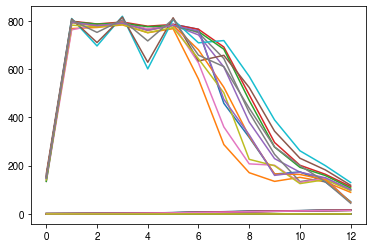

In [25]:
# GENERATE EPISODE POOL
from casadi import *
import numpy as np
from ANN_for_MPC_pretraining.utilities import MPC
import matplotlib.pyplot as plt

episode_pool = []
for k in range(400):
    dp = np.random.multivariate_normal([0]*11, Cov)

    System     = Bio_reactor
    System_unc = Bio_reactor_unc
    N =12 # This is the total steps
    #Initialize system
    Sys = System_unc()
    dt, x0, _, _, _ = Sys.specifications()
    F = Sys.integrator_model()
    # Construct MPC
    MPC_ = MPC(System, horizon=N, penalize_u=False) 
    # Define system

      # Initialize Matrices
    his_x = np.zeros([1000, len(x0)])
    his_u = np.zeros([1000, 2])
    t     = 0.
    u_apply = np.array([0.])

    for i in range(12):
        his_x[i] = x0
        u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, t=t) # Deterministic Model

        u_apply  = np.array(u_opt)[:,0]
        his_u[i] = u_apply
        x1 = F(x0=x0, p=vertcat(u_apply, dp))           # Real System
        x0 = np.array(x1['xf']).reshape((-1,))
        t += dt
        if i == 11:
            his_x[i+1] = x0
            his_u[i+1] = u_apply
    plt.plot(his_x[:N+1])

    Cx_list = his_x[:,0][:13]
    Cn_list = his_x[:,1][:13]
    Cq_list = his_x[:,2][:13]
    u_Fn_list = his_u[:,1][:13]
    u_L_list  = his_u[:,0][:13]
    t_list = np.arange(0,260, 20)
    episode = []
    for i in range(len(Cx_list)):
        state   = [Cx_list[i], Cn_list[i], Cq_list[i], t_list[i]]
        control = [u_Fn_list[i], u_L_list[i]]
        if i == range(len(Cx_list))[-1]:
            reward = Cq_list[i]
        else:
            reward = 0
        episode += [[state, control, reward]]
    episode_pool += [episode]

In [27]:
## For comparison of MPC and oracle Q-learning speed of generating actions
from ANN_for_MPC_pretraining.utilities import MPC
System = Bio_reactor
System_unc = Bio_reactor_unc
N =12 # This is the total steps
#Initialize system
Sys = System_unc()
dt, x0, _, _, _ = Sys.specifications()
F = Sys.integrator_model()
# Construct MPC
MPC_ = MPC(System, horizon=N, penalize_u=False) 
# Define system

# Initialize Matrices
his_x = np.zeros([1000, len(x0)])
his_u = np.zeros([1000, 2])
u_apply = np.array([0.])


import time

times = []
for i in range(1000):
    x0 = np.array([1., 150., 0.])
    t  = 0.
    start_time = time.time()
    u_opt, x_opt, w_opt = MPC_.solve_MPC(x=x0, t=t) # Deterministic Model
    t = time.time() - start_time
#     print("--- %s seconds ---" % (t))
#     print(u_opt, x_opt, w_opt)
    times += [t]

In [28]:
# MPC
print("mean time per action (s): %s" % np.mean(times))
print("mean time per action (s): %s" % np.std(times))   

mean time per action (s): 0.41082407236099244
mean time per action (s): 0.10067015398331558


In [154]:
# DEFINE PLOTTING FUNCTIONS
def violate_g1(Cn):
    if Cn > 800:
        return True
    else:
        return False

def violate_g2(Cq, Cx):
    if Cq - 0.011*Cx > 0:
        return True
    else:
        return False    
    
def violate_g3(Cn):
    if Cn > 150:
        return True
    else:
        return False    

def plot_episode_pool(episode_pool):
    '''Plots an episode pool (n number of episodes) and corresponding score'''
    episodes_g1_violated = 0 # No. of episodes that violate g1
    episodes_g2_violated = 0 # No. of episodes that violate g2
    episodes_g3_violated = 0 # No. of episodes that violate g3
    episodes_g1g2g3_any_violated = 0 # No. of episodes that violate either g1 and g2
    total_score = 0
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
    Cx_pool  = []
    Cn_pool  = []
    Cq_pool  = []
    u_Fn_pool = []
    u_L_pool = []
    
    for idx in range(len(episode_pool)): # Idx refers to nth episode in episode pool
        episode = episode_pool[idx]
        Cx_list  = []
        Cn_list  = []
        Cq_list  = []
        t_list   = []
        u_Fn_list = []
        u_L_list = []
        reward_list = []
        t = 0.
        for step in episode:
            [Cx, Cn, Cq, _], [u_Fn, u_L], reward = step
            Cx_list  += [Cx]
            Cn_list  += [Cn]
            Cq_list  += [Cq]
            t_list   += [t]
            u_Fn_list += [u_Fn]
            u_L_list += [u_L]
            reward_list += [reward]
            t += 20.
    #     fig, ax = plt.figure(figsize=(10,10))
        
        # Add scores to total score
        score        = Cq_list[-1]
        total_score += score
        
        # Count number of EPISODES that have violation
        if True in map(violate_g1, Cn_list):
            episodes_g1_violated += 1
        for j in range(len(Cq_list)):
            if violate_g2(Cq_list[j], Cx_list[j]):
                episodes_g2_violated += 1
                break
        if violate_g3(Cn_list[-1]):
            episodes_g3_violated += 1

        if True in map(violate_g1, Cn_list):
            episodes_g1g2g3_any_violated += 1
        elif violate_g3(Cn_list[-1]):
            episodes_g1g2g3_any_violated += 1
        else:
            for j in range(len(Cq_list)):
                if violate_g2(Cq_list[j], Cx_list[j]):
                    episodes_g1g2g3_any_violated += 1
                    break
        
        Cx_pool  += [Cx_list]
        Cn_pool  += [Cn_list]
        Cq_pool  += [Cq_list]
        u_Fn_pool += [u_Fn_list]
        u_L_pool += [u_L_list]
        
        plt.subplot(3,3,1)
        plt.plot(t_list, Cx_list, color = 'grey', alpha = 0.5)
        plt.legend(fontsize = 15)

        plt.subplot(3,3,2)
        plt.plot(t_list, Cn_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,3)
        plt.plot(t_list, Cq_list, color = 'grey', alpha = 0.5)
        
        plt.subplot(3,3,4)
        plt.step(t_list, u_Fn_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,5)
        plt.step(t_list, u_L_list, color = 'grey', alpha = 0.5)
    
    Cx_pool  = np.array(Cx_pool)
    Cn_pool  = np.array(Cn_pool)
    Cq_pool  = np.array(Cq_pool)
    u_Fn_pool = np.array(u_Fn_pool)
    u_L_pool = np.array(u_L_pool)
    
    # Take mean of all columns (all time steps)
    Cx_avg_list  = Cx_pool.mean(axis=0)
    Cn_avg_list  = Cn_pool.mean(axis=0)
    Cq_avg_list  = Cq_pool.mean(axis=0)
    u_Fn_avg_list = u_Fn_pool.mean(axis=0)
    u_L_avg_list = u_L_pool.mean(axis=0)
    
    # Find +/- one STD of all columns
#     T_std_upper = np.percentile(T_pool, 84, axis = 0)
#     T_std_lower = np.percentile(T_pool, 16, axis = 0)
    
#     Vol_std_upper = np.percentile(Vol_pool, 84, axis = 0)
#     Vol_std_lower = np.percentile(Vol_pool, 16, axis = 0)
    
    plt.subplot(3,3,1)
    plt.plot(t_list, Cx_avg_list, label = 'x trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,2)
    plt.plot(t_list, Cn_avg_list, label = 'N trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,3)
    plt.plot(t_list, Cq_avg_list, label = 'q trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,4)
    plt.step(t_list, u_Fn_avg_list, label = 'u_Fn trajectory', color = 'r')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,5)
    plt.step(t_list, u_L_avg_list, label = 'u_L trajectory', color = 'r')
    plt.legend(fontsize = 15)
    
    fig.tight_layout()
    fig.delaxes(ax[1][2]) # delete last 6th plot (empty)
    fig.delaxes(ax[2][0]) # delete last 7th plot (empty)
    fig.delaxes(ax[2][1]) # delete last 8th plot (empty)
    fig.delaxes(ax[2][2]) # delete last 9th plot (empty)
    plt.show()
    
    avg_score = total_score/len(episode_pool)
    print('Score:', avg_score)
    print('total no. of episodes:', len(episode_pool))
    print('episodes that violate g1:',episodes_g1_violated) 
    print('episodes that violate g2:',episodes_g2_violated)
    print('episodes that violate g3:',episodes_g3_violated)
#     print('episodes that violate both g1 and g2:',episodes_g1g2_both_violated)
    print('episodes that violate any constraint:',episodes_g1g2g3_any_violated)

In [155]:
# SAVING EPISODE POOL - JSON WORKS BUT NOT PICKLE BCOS NESTED LIST
import json
class NpEncoder(json.JSONEncoder): 
    def default(self, obj):
        if isinstance(obj, numpy.float64):
            return float(obj)
        if isinstance(obj, numpy.int):
            return float(obj)
# open output file for writing
# with open('./Data/CS1_episode_pool_MPC_50%_noise_noisy_init', 'w') as f:
#     json.dump(episode_pool, f, cls=NpEncoder)
# open output file for reading
# with open('./Data/CS1_episode_pool_MPC_50%_noise_noisy_init', 'r') as f:
#     episode_pool = json.load(f)

No handles with labels found to put in legend.
<ipython-input-154-a50fb7b16c6f>:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,1)
No handles with labels found to put in legend.
<ipython-input-154-a50fb7b16c6f>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,2)
<ipython-input-154-a50fb7b16c6f>:92: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

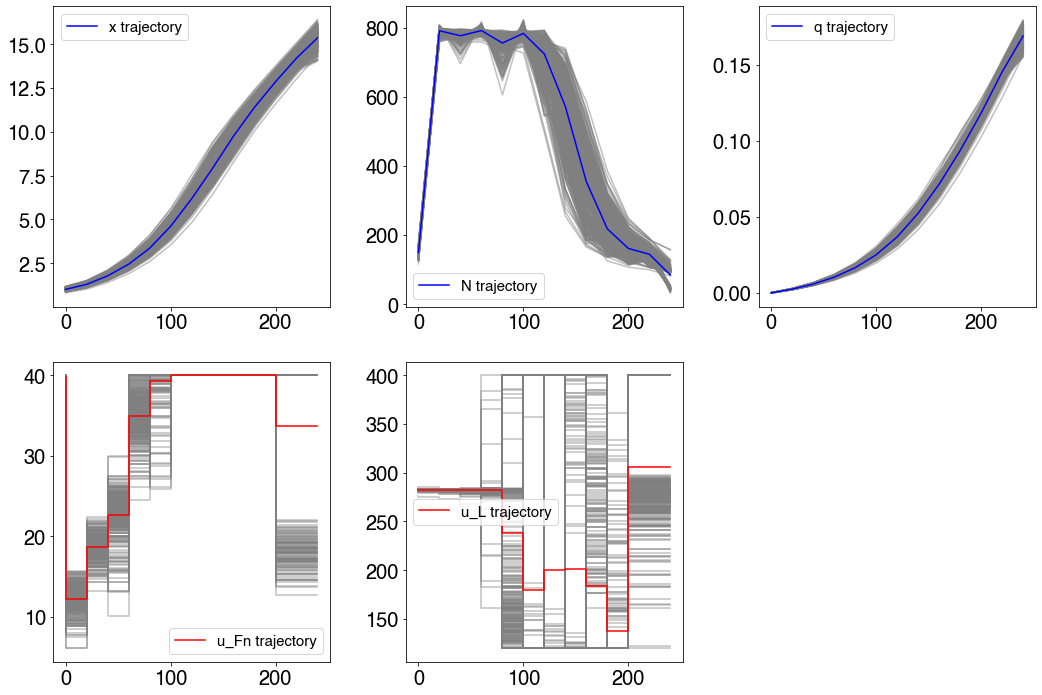

Score: 0.16902695916085148
total no. of episodes: 400
episodes that violate g1: 53
episodes that violate g2: 180
episodes that violate g3: 2
episodes that violate any constraint: 181


In [156]:
plot_episode_pool(episode_pool)